# This notebook extracts instability times from the simulation archives

In [1]:
import rebound
import reboundx
import numpy as np
import sys
import os
import re
import pandas as pd

df = pd.DataFrame(columns=('K','mag','filename'))

datapath = 'data/'
for filename in os.listdir(datapath):
    result = re.search(r"IC(.*)K(.*)mag(.*).bin", filename)
    if result:
        simID = int(result.group(1))
        K = float(result.group(2))
        mag = float(result.group(3))
        filename='IC{0}K{1:.4e}mag{2:.4e}.bin'.format(simID, K, mag)
        df.loc[simID] = [K,mag,filename]
        
df = df.sort_index()
df.tail()

,K,mag,filename
984,28.237,0.076254,IC984K2.8237e+01mag7.6254e-02.bin
986,201.970,0.052832,IC986K2.0197e+02mag5.2832e-02.bin
990,914.570,0.006452,IC990K9.1457e+02mag6.4517e-03.bin
995,53.041,0.903500,IC995K5.3041e+01mag9.0350e-01.bin
997,77.841,0.530970,IC997K7.7841e+01mag5.3097e-01.bin


The first 24 simIDs were run for 50 Myr, while the rest were run for 5 Myr. Unfortunately, due to an oversight the planet radii were not set to the appropriate Hill radii as a stopping condition for the simulations, so they all ran until the maximum time. So we need to more work to find the instability times.

In [2]:
df['tmax'] = 5e6
df.loc[:65,'tmax'] = 5e7 # first 24 simulations run to 5e7
df.head(25)

,K,mag,filename,tmax
0,125.210,0.139820,IC0K1.2521e+02mag1.3982e-01.bin,50000000.0
2,74.471,0.001196,IC2K7.4471e+01mag1.1961e-03.bin,50000000.0
4,859.130,0.043822,IC4K8.5913e+02mag4.3822e-02.bin,50000000.0
6,610.550,0.009907,IC6K6.1055e+02mag9.9069e-03.bin,50000000.0
7,14.211,0.218650,IC7K1.4211e+01mag2.1865e-01.bin,50000000.0
8,558.290,0.804680,IC8K5.5829e+02mag8.0468e-01.bin,50000000.0
10,348.850,0.001154,IC10K3.4885e+02mag1.1541e-03.bin,50000000.0
13,359.260,0.005160,IC13K3.5926e+02mag5.1597e-03.bin,50000000.0
15,498.470,0.003441,IC15K4.9847e+02mag3.4410e-03.bin,50000000.0
16,27.963,0.037110,IC16K2.7963e+01mag3.7110e-02.bin,50000000.0


In [3]:
%%time
datapath = '../data'
df['tinstability'] = df.apply(lambda x: rebound.Simulation.from_archive(datapath+x['filename']).t, axis=1)
df.tail()

CPU times: user 48 ms, sys: 17 ms, total: 65 ms
Wall time: 78.2 ms


/mnt/raid-cita/dtamayo/p3new/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/p3new/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: Unknown field found in binary file.
  warnings.warn(message, RuntimeWarning)


We will use the energy errors to find the unstable systems, since the Wisdom-Holman energy error depends on how close planets get to one another. Here we calculate the energy error at the beginning of the simulation (between the first two snapshots 1000 years apart), and between the beginning and the end of the entire simulation.

In [4]:
%%time
def Eerr1(row):
    sa = rebound.SimulationArchive(datapath+row['filename'])
    E0 = sa[0].calculate_energy()
    E1 = sa[1].calculate_energy()
    return abs((E1-E0)/E0)
    
def Eerrf(row):
    sa = rebound.SimulationArchive(datapath+row['filename'])
    E0 = sa[0].calculate_energy()
    E1 = sa[-1].calculate_energy()
    return abs((E1-E0)/E0)
    
df['Eerr1'] = df.apply(Eerr1, axis=1)
df['Eerrf'] = df.apply(Eerrf, axis=1)
df.tail()

/mnt/raid-cita/dtamayo/p3new/lib/python3.4/site-packages/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


CPU times: user 114 ms, sys: 50 ms, total: 164 ms
Wall time: 168 ms


The relative energy error is $\epsilon \tau^2$, where $\tau$ is the timestep in units of orbital periods, and $\epsilon$ is the strength of the interplanetary interactions relative to the graviational interaction with the central body. When particles come within a Hill radius of one another, $\epsilon \sim 1$, so since we use $\tau = 0.07$ times the innermost orbital period, this corresponds to a fractional energy error $\sim 10^{-2}$.

At the beginning of the simulation the interplanetary spacings are large, so the error is small.

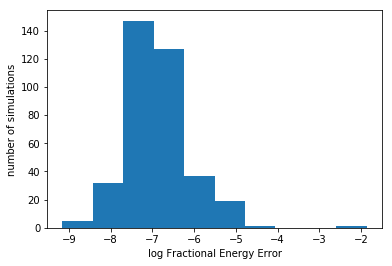

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(np.log10(df['Eerr1']))
ax.set_xlabel("log Fractional Energy Error")
ax.set_ylabel("number of simulations")

By the end of the simulation, the unstable systems separate cleanly. We tested that the systems with order unity energy error indeed went unstable, and that the ones below $10^{-2}$ had remained stable through the end of the simulation.

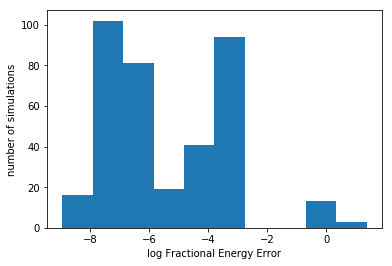

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(np.log10(df['Eerrf']))
ax.set_xlabel("log Fractional Energy Error")
ax.set_ylabel("number of simulations")

Finally, for each unstable system, we find the snapshot at which the energy error crossed the threshold, then from the previous one integrate forward this time setting the particle radii to the innermost planet's Hill radius (the smallest, most conservative one), and make sure that integrating forward from that point we get a Hill sphere crossing. We then update the dataframe with the instability time, and the index in the simulation archive where it happened.

In [7]:
def instabilitytime(row):
    print(row.name)
    maxdistance=1. # stop if any planet gets beyond this many AU
    sa = rebound.SimulationArchive(datapath+row['filename'])
    if row['Eerrf'] < 1.e-2:
        row['tinstability_index'] = np.nan
        row['tinstability'] = sa[-1].t
        return row
    E0 = sa[0].calculate_energy()
    Eerr = np.zeros(len(sa))
    times = np.zeros(len(sa))
    for i, sim in enumerate(sa):
        times[i] = sim.t
        Ef = sim.calculate_energy()
        Eerr[i] = abs((Ef-E0)/E0)
        unstable=False
        if Eerr[i] > 1.e-2:
            unstable=True
        for p in sim.particles[1:]:
            if p.d > maxdistance:
                unstable=True
        if unstable is True:
            row['tinstability_index'] = i-1
            break
            
    tnext = sim.t
    sim = sa[i-1]
    ps = sim.particles
    Hillradius = (ps[1].m/(3.*ps[0].m))**(1./3.)*ps[1].a
    for p in sim.particles[1:]:
        p.r = Hillradius

    def collision(reb_sim, col):
        reb_sim.contents._status = 5
        return 0
    sim.collision = "direct"
    sim.collision_resolve = collision
    sim.exit_max_distance=maxdistance
    
    try:
        sim.integrate(tnext, exact_finish_time=0)
    except rebound.Escape as error:
        sim._status = 5
        
    if sim._status == 5:
        row['tinstability'] = sim.t
    else:
        row['tinstability'] = sa[-1].t
    return row

In [8]:
%%time
print("simID")
print("-----")
df = df.apply(instabilitytime, axis=1)

simID
-----
0
0
2
4
6


/mnt/raid-cita/dtamayo/p3new/lib/python3.4/site-packages/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


7
8
10
13
15
16
17
18
19
22
27
29
30
35
36
37
46
51
55
62
70
73
76
83
92
93
94
98
100
101
111
118
119
120
123
125
127
130
131
141
142
146
147
149
152
154
159
162
163
167
168
174
178
179
188
190
191
192
196
197
198
201
203
204
205
214
215
220
221
222
223
226
228
235
237
239
240
241
243
245
247
248
251
255
257
259
261
270
272
282
283
288
289
290
293
294
295
301
308
310
311
314
316
317
318
320
328
332
337
345
347
350
352
357
358
359
360
363
364
365
369
371
373
376
377
379
382
383
384
386
387
388
392
400
401
406
407
411
412
413
420
421
423
425
429
433
434
435
437
439
441
442
443
445
446
447
449
450
451
452
453
454
455
458
460
462
463
467
469
471
472
473
476
480
482
485
486
488
490
492
493
494
495
497
499
501
504
506
508
509
510
515
516
517
521
525
531
537
540
541
544
546
548
550
553
556
559
561
566
569
570
574
575
577
581
583
584
587
590
591
597
602
604
605
607
609
614
620
622
623
629
631
632
635
636
637
640
642
644
645
646
647
650
652
657
658
659
660
668
669
672
675
678
679
684
685
688
69

In [9]:
df.to_csv("csvs/instabilitytimes.csv", encoding='ascii')

In [10]:
df.head(25)

,K,mag,filename,tmax,tinstability,Eerr1,Eerrf,tinstability_index
0,125.210,0.139820,IC0K1.2521e+02mag1.3982e-01.bin,50000000.0,5.000000e+07,5.822356e-08,4.967208e-07,NaN
2,74.471,0.001196,IC2K7.4471e+01mag1.1961e-03.bin,50000000.0,5.000000e+07,3.297564e-07,2.164101e-07,NaN
4,859.130,0.043822,IC4K8.5913e+02mag4.3822e-02.bin,50000000.0,5.000000e+07,3.569262e-08,5.113791e-04,NaN
6,610.550,0.009907,IC6K6.1055e+02mag9.9069e-03.bin,50000000.0,2.869029e+06,2.234090e-06,8.162635e-01,2869.0
7,14.211,0.218650,IC7K1.4211e+01mag2.1865e-01.bin,50000000.0,5.000000e+07,3.204928e-08,1.226401e-03,NaN
8,558.290,0.804680,IC8K5.5829e+02mag8.0468e-01.bin,50000000.0,3.773222e+04,2.968038e-07,1.441254e+00,37.0
10,348.850,0.001154,IC10K3.4885e+02mag1.1541e-03.bin,50000000.0,5.000000e+07,2.518669e-07,4.269432e-04,NaN
13,359.260,0.005160,IC13K3.5926e+02mag5.1597e-03.bin,50000000.0,5.000000e+07,3.279304e-07,3.699621e-07,NaN
15,498.470,0.003441,IC15K4.9847e+02mag3.4410e-03.bin,50000000.0,5.000000e+07,5.208768e-08,6.534782e-08,NaN
16,27.963,0.037110,IC16K2.7963e+01mag3.7110e-02.bin,50000000.0,4.349277e+06,6.298385e-07,1.236243e+00,4349.0
